# Spotify Recommendation
## Author: Fei Wu
### part I data ingestion

We are using Spotify Million Playlist Dataset for this project.
1000 json files that stores playlist info, we want to incorporate song information such as accounticness, dancibility...etc as well

In [40]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import time
import pprint as pp
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from tabulate import tabulate
#Authentication - without user
cid = '8846ee3eb88148599920d8096724f7bd'
secret = 'a60d08bbbaf540a5bb1da93285da5d5a'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [9]:
playlist_data = json.load(open("../data/raw/spotify_million_playlist_dataset/data/mpd.slice.0-999.json"))
playlists = playlist_data["playlists"]
df = pd.DataFrame(playlists)
df.head(5)

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,Throwbacks,false,0,1493424000,52,47,1,"[{'pos': 0, 'artist_name': 'Missy Elliott', 't...",6,11532414,37,NaN
1,Awesome Playlist,false,1,1506556800,39,23,1,"[{'pos': 0, 'artist_name': 'Survivor', 'track_...",5,11656470,21,NaN
2,korean,false,2,1505692800,64,51,1,"[{'pos': 0, 'artist_name': 'Hoody', 'track_uri...",18,14039958,31,NaN
3,mat,false,3,1501027200,126,107,1,"[{'pos': 0, 'artist_name': 'Camille Saint-Saën...",4,28926058,86,NaN
4,90s,false,4,1401667200,17,16,2,"[{'pos': 0, 'artist_name': 'The Smashing Pumpk...",7,4335282,16,NaN


In [29]:
def readToDf(jsfile):
    playlist_data = json.load(open(jsfile))
    playlists = playlist_data["playlists"]
    df = pd.DataFrame(playlists)

    # Rename the columns to match the desired column names
    df.rename(columns={"name": "playlist_name"}, inplace=True)

    # Explode the track data to create separate rows for each track
    df = df.explode("tracks")
    
    # Create separate columns for "track_name," "track_uri," and "artist_name"
    expand_columns = list(playlist_data["playlists"][0]['tracks'][0].keys())
    df[expand_columns] = df["tracks"].apply(pd.Series)

    # Drop the original "track_data" column
    df.drop(columns=["tracks"], inplace=True)
    #why are we using pySpark
    df.reset_index(inplace=True, drop=True)
    #df.to_pickle("../data/processed/playlist.pkl")
    return df

In [34]:
filep = "../data/raw/spotify_million_playlist_dataset/data/mpd.slice.0-999.json"
df1 = readToDf(filep)
#print(tabulate(df1.head(5), headers='keys', tablefmt='psql'))
df1.head(3)

,playlist_name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,description,pos,artist_name,track_uri,artist_uri,track_name,album_uri,album_name
0,Throwbacks,false,0,1493424000,52,47,1,6,226863,37,NaN,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,The Cookbook
1,Throwbacks,false,0,1493424000,52,47,1,6,198800,37,NaN,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,In The Zone
2,Throwbacks,false,0,1493424000,52,47,1,6,235933,37,NaN,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,Dangerously In Love (Alben für die Ewigkeit)


In [30]:
#takes the directory of storing json file, convert to dfs with corresponding [playlist+song]
def data_ingestion(path):
    dfs=[]
    files = glob.glob(path + '/*.json')
    j = [i for i in range(1, 11)]
    for i, file in enumerate(files[:20]):
        with open(file) as f:
            df = readToDf(file)
            dfs.append(df)
    return pd.concat(dfs)

In [31]:
path = '../data/raw/spotify_million_playlist_dataset/data'
output_sample = data_ingestion(path)
print(output_sample.shape)
output_sample.to_pickle('../data/processed/sample.pkl')

(1327468, 18)


### Some EDA before we move on to feature extraction from API

In [37]:
#how many unique songs?
output_sample.track_name.nunique()

200608

In [38]:
output_sample.artist_name.nunique()

50071

In [78]:
#tops songs and top artists
hot_track = output_sample.track_name.value_counts()[:20]
hot_artist = output_sample.artist_name.value_counts()[:20]

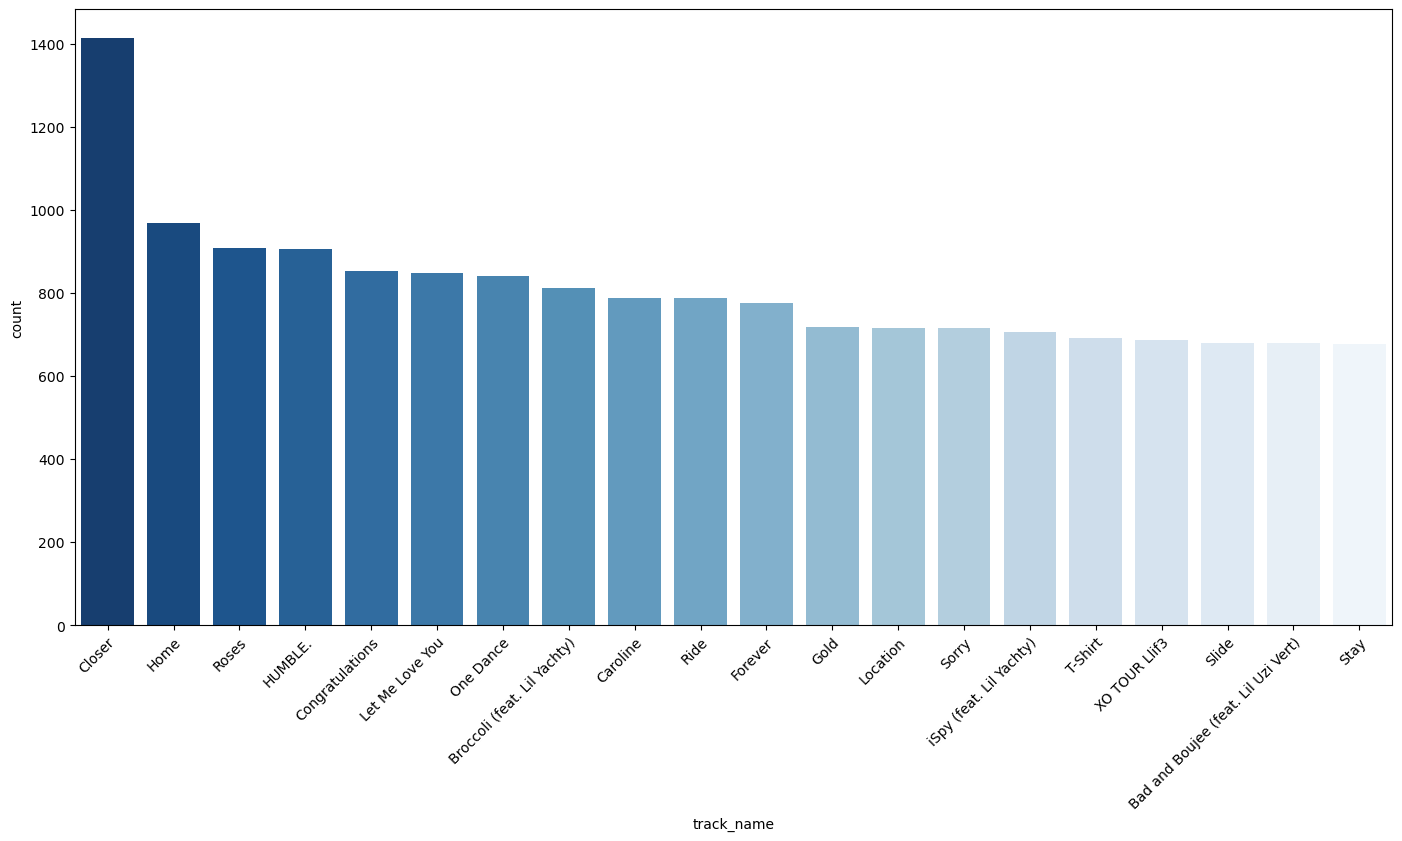

In [80]:
hot_track = hot_track.reset_index().rename(columns = {'index': 'Series Index', 0: 'Series Values'})
plt.figure(figsize=(17, 8))
sns.barplot(df, x="track_name", y="count", palette=reversed(sns.color_palette("Blues", 20)))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor');

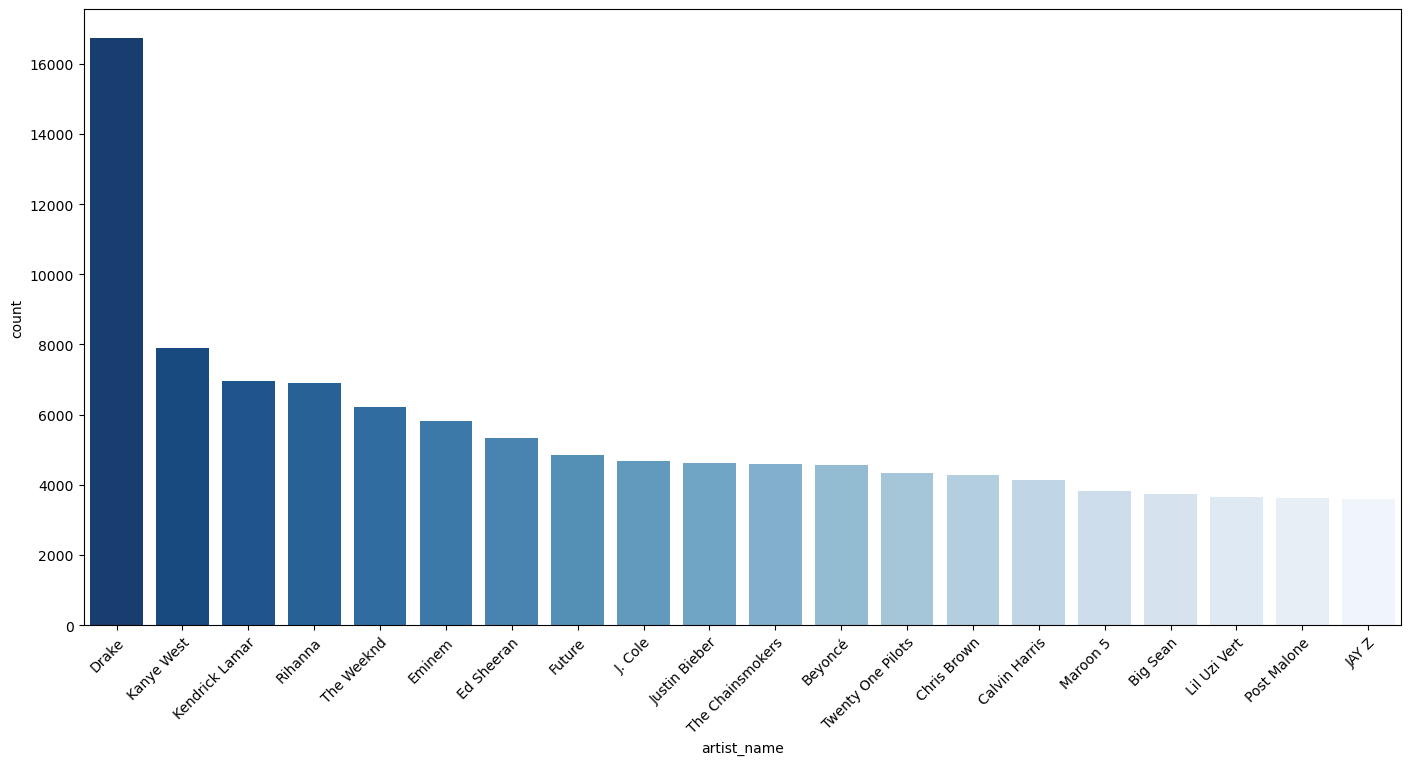

In [81]:
hot_artist = hot_artist.reset_index().rename(columns = {'index': 'Series Index', 0: 'Series Values'})
plt.figure(figsize=(17, 8))
sns.barplot(hot_artist, x="artist_name", y="count", palette=reversed(sns.color_palette("Blues", 20)))
plt.xticks(rotation=45, ha='right', rotation_mode='anchor');

In [82]:
output_sample.head()

,playlist_name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,description,pos,artist_name,track_uri,artist_uri,track_name,album_uri,album_name
0,Bob Dylan,false,549000,1454803200,75,65,1,28,277106,39,NaN,0,Bob Dylan,spotify:track:6QHYEZlm9wyfXfEM1vSu1P,spotify:artist:74ASZWbe4lXaubB36ztrGX,Boots of Spanish Leather,spotify:album:7DZeLXvr9eTVpyI1OlqtcS,The Times They Are A-Changin'
1,Bob Dylan,false,549000,1454803200,75,65,1,28,330533,39,NaN,1,Bob Dylan,spotify:track:3RkQ3UwOyPqpIiIvGVewuU,spotify:artist:74ASZWbe4lXaubB36ztrGX,Mr. Tambourine Man,spotify:album:1lPoRKSgZHQAYXxzBsOQ7v,Bringing It All Back Home
2,Bob Dylan,false,549000,1454803200,75,65,1,28,254653,39,NaN,2,Loggins & Messina,spotify:track:0ju1jP0cSPJ8tmojYBEI89,spotify:artist:7emRV8AluG3d4e5T0DZiK9,Danny's Song,spotify:album:5BWgJaesMjpJWCTU9sgUPf,The Best: Loggins & Messina Sittin' In Again
3,Bob Dylan,false,549000,1454803200,75,65,1,28,412200,39,NaN,3,Bob Dylan,spotify:track:7ny2ATvjtKszCpLpfsGnVQ,spotify:artist:74ASZWbe4lXaubB36ztrGX,A Hard Rain's A-Gonna Fall,spotify:album:0o1uFxZ1VTviqvNaYkTJek,The Freewheelin' Bob Dylan
4,Bob Dylan,false,549000,1454803200,75,65,1,28,165426,39,NaN,4,Bob Dylan,spotify:track:18GiV1BaXzPVYpp9rmOg0E,spotify:artist:74ASZWbe4lXaubB36ztrGX,Blowin' In the Wind,spotify:album:0o1uFxZ1VTviqvNaYkTJek,The Freewheelin' Bob Dylan


In [91]:
#distribution of songs counts of playlists:
artist_names=output_sample.artist_name.value_counts().index.values
album_names=output_sample.album_name.value_counts().index.values
output_sample.groupby('playlist_name').count()

,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists,description,pos,artist_name,track_uri,artist_uri,track_name,album_uri,album_name
playlist_name,,,,,,,,,,,,,,,,,
ok,40,40,40,40,40,40,40,40,40,0,40,40,40,40,40,40,40
'17,50,50,50,50,50,50,50,50,50,0,50,50,50,50,50,50,50
( ͡° ͜ʖ ͡°),107,107,107,107,107,107,107,107,107,0,107,107,107,107,107,107,107
(throwback),198,198,198,198,198,198,198,198,198,0,198,198,198,198,198,198,198
Acoustic,34,34,34,34,34,34,34,34,34,0,34,34,34,34,34,34,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
🤤🤤,53,53,53,53,53,53,53,53,53,0,53,53,53,53,53,53,53
🤷‍♀️,104,104,104,104,104,104,104,104,104,0,104,104,104,104,104,104,104
🤷🏼‍♀️,80,80,80,80,80,80,80,80,80,0,80,80,80,80,80,80,80


In [102]:
playlist_string = ' '.join(output_sample['playlist_name'].unique())

In [95]:
%pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/ac/66/937d1d73389c0b501c928c4d8513653063d2b40272dff70d0e283d8b9144/wordcloud-1.9.3-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 6.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


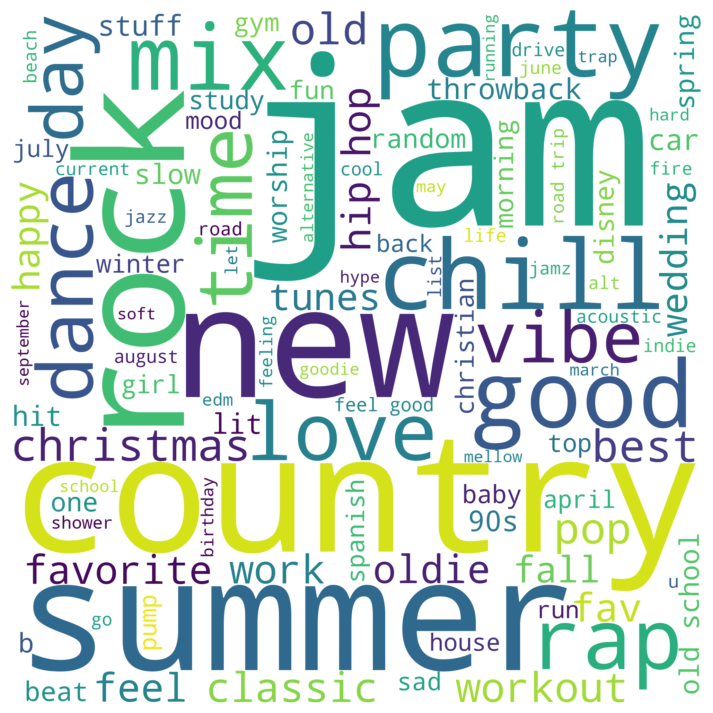

In [127]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from PIL import Image
stopws=['song', 'playlist', 'music', 'songs', 'the']
STOPWORDS.update(stopws)
#mask = np.array(Image.open('/Users/postgres/Desktop/projects/recommendation_system/assets/logo.png'))
plt.figure(figsize=(16, 9))
wc = WordCloud(stopwords = STOPWORDS, width = 2000, height =2000, max_words = 100,background_color='white').generate(playlist_string.lower())
# Remove the axis and display the data as image
plt.axis("off")
plt.imshow(wc, interpolation = "bilinear")

### Feature Extraction with Spotipy API

In [190]:
#extract song features from Spotipy API
def _checkpoint(i: int, feature: list):
    feature_df = pd.DataFrame(features)
    rows = feature_df.shape[0]
    songs = df.iloc[:rows+1]
    songs = pd.concat([songs, feature_df], axis=1)
    songs.to_pickle('../data/processed/feature{}.pkl',format(i))

def extract_audio_feature(df, k=99):
    '''
    df: dataframe contains a column of "track_uri" 
    process this by 100 per time due to the API limit 

    return: extended dataframe with audio feature columns
    '''
    features = []
    batch = df.shape[0]//k
    for i in range(batch):
        melt = df.iloc[i*k: i*k + k]['track_uri']
        melt = melt.to_list()
        features = features + sp.audio_features(melt)
        time.sleep(30)
        if i%100 == 0:
            print(10000*i/df.shape[0], "% done")
            time.sleep(5)
    #last batch - updated i 
    if df.shape[0]%k != 0: 
        melt=df.iloc[i*k+k:]['track_uri']
        melt = melt.to_list()
        features = features + sp.audio_features(melt)
    feature_df = pd.DataFrame(features)
    rows = feature_df.shape[0]
    songs = df.iloc[:rows+1]
    songs = pd.concat([songs, feature_df], axis=1)
    songs.to_pickle('../data/processed/feature.pkl')
    return songs


def extract_sentiment_score(df):
    """
    df: a dataframe contains column 'track_name' 
    output: a extended dataframe that contains 2 new column 'subjectivity' and 'polarity'
    """
    df['polarity'] = df['track_name'].astype(str).apply(lambda name: TextBlob(name).sentiment.polarity)
    df['subjectivity'] = df['track_name'].astype(str).apply(lambda name: TextBlob(name).sentiment.subjectivity)
    return df


def scale_feature(df):
    """
    Scale numeric features for songs in db
    output: df scaled
    """
    scaler = MinMaxScaler()
    #numeric cols:
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    # Returning the scaled dataframe
    return df

In [187]:
#is it possible to scral all at once:?
feature_df = extract_audio_feature(output_sample.iloc[0:])

Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=5rmcjZTrE9JR1YrbNZDFNW,1vvnYpYEMVB4aq9I6tHIEB,30Chv2SmIry70YwtmtaKnj,4gkl7QbQvBd3TM9PhlWFkI,01VGA34ATxwp0Xo1ldduo2,1uxdxSC2bfUFYVqxvejVC3,7GUVaGNiu11HXN2aqF6Rir,2pBymUtAkPVvdS06nd27N1,5iSEsR6NKjlC9SrIJkyL3k,0osPUefhvYxoB2eZw6prBt,3cc66vpbbkDNgtSnWgKked,7BHPGtpuuWWsvE7cCaMuEU,5UHuuQGEgMbZrYnHjQG9ny,7wBrglFVTNCcW6IhdgBkm1,7e8utCy2JlSB8dRHKi49xM,2l57cfmCnOkwNX1tky02n1,4o0NjemqhmsYLIMwlcosvW,2qEv3RLo2KTgjP844901gV,2qg9LM2wkJpSejzZkbZIDg,2rvHIXjN4TCFuFLZk3qAxn,0Gi17qCJh9e9RJxLaYkm9l,047fCsbO4NdmwCBn8pcUXl,6ZrlXT6mUMEgomN128iekU,464XjjRcO8no1YY9amYKbv,2tznHmp70DxMyr2XhWLOW0,0FDzzruyVECATHXKHFs9eJ,5yaO6I0gPMq6OgkroE7Pfd,6YUTL4dYpB9xZO5qExPf05,4CEBOa0v6ZGKRPIzQdHJrw,5yuShbu70mtHXY0yLzCQLQ,3iVAyrTlbWGBq0laeQ18z2,0iTpQYzJnYgh7kIxyq8A2O,7MiZjKawmXTsTNePyTfPyL,2yJVeT8cP1zstJxRP7Nlv8,3K5yco4dmG5L3mR554riLv,6ZYS6QQxTLsQ6IFXdVx1r4,7129iqBafaphfc3WPCGC0L,3LFhPZqd9GC9sV8ZTnu99P,68Ap3Fp1mTg0TdA5o67zc1,3YsQHfa0JcuUTOHMo5NsGK,0vaf64cpnqM7COUZZkoBig,5QldjuXcxplhjjUqLrzl6H,7jB5W0Tjs0C5MUgehMkLjF,4RCWB3V8V0dignt99LZ8vH,2QjOHCTQ1Jl3zawyYOpxh6,2MLHyLy5z5l5YRp7momlgw,5nHRIKsXDwUpse9gzrAxLR,3CRDbSIZ4r5MsZ0YwxuEkn,28YLWwEB6xnJQYN7e062rH,0GL1ye91pT3nJIQzXwncG2,6ZT3coOj97F6CVvruPtnox,1znPMY3zq78mVuTAmOA9O7,7FvS9PhfQkRRSYnw8IqWYC,2H3wWrnO758y0fPH7Ilerg,5TXDeTFVRVY7Cvt0Dw4vWW,2UwbhMie1EAYuTZ0QXeMwl,2vQwlW8H1jFveGNXwZfJCV,2yZax79pOrYuyIFVW2cZY2,05bnEv2dpFzmGVLGdjD9UP,0oaDRTXybxwtiyOWqOhJoC,2hmibAtdObO8F4tnhLENuQ,0Nq92tx5brQ2mg2ChMmMOf,4z8c9qkpiYghn6DCQ6yA0u,4eucKRPayKSzwxaOOGfhye,64ABGM1MLV3xoHpgLqJwJ4,3AVrVz5rK8Hrqo9YGiVGN5,7esYLvFrtQ2G2wQHROffga,55zck3jlMBQEAHnf6PRljL,4x2KdMk38UklF9JjTWXH57,60ZZNXIdwgUGkVGRt7foLT,4CdXMT8pEVXFRbDKLPaeXA,3SqvR3HYLlCTYzbDXJ52OC,25ftvBo8tBHwathOzuVLLA,4pFNMSkCmEHk8U408TmQTE,2s1tc8yYKf0QAO70Xe1VjU,7w9bgPAmPTtrkt2v16QWvQ,2xMS1khdU5FHX1KEiNTVdi,1jNOi6m3Hn8nLEeHCp5Msr,7hsLKGEnoiNShdIGL6ws1f,3zmduBNsQ6BPDTZAkXzG5K,0bVtevEgtDIeRjCJbK3Lmv,5OOkp4U9P9oL23maHFHL1h,6G7URf5rGe6MvNoiTtNEP7,15qf0H31MChhqKr2zvejla,2JI71GHwq2LN8mtq3iCLYo,05HNjbWZuDRdN0l4BVkRk9,6zrWo6LSRhopY4NFZgUYOW,1rnXV4bem7S9ceL2snZ08u,2YXrYFN4le88OlsQYb9FcD,2ukSGKuNwVDvJ7vA2RPwT4,1TwiB6WkwPkpibnrJVhA0O,3GaIhMRYflNE1oER797AaM,73cxDSbS2p3xP0Qrl8rzKy,2mNQYsAPM2lwSpG8BCcqXt,5EPMZ6PSwiQ0n33FNiuSgP,0WKY4nRJgz3GUG7IqkTgUH,5dclpFokYTrD629C3SJ3yw,1YmJPxRLUQ8UU0zb8cnnFK,3aVLHXxmo6fHFA7xTWlgR1:
 Max Retries, reason: too many 429 error responses

In [147]:
print(songs)

NameError: name 'songs' is not defined

In [192]:
test_df = extract_audio_feature(output_sample.iloc[:200])
test_df.head(5)
test_df.loc[10, 'analysis_url']

0.0 % done


Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=1ErzaSeWk9TvWdRgrFYwl0,5TTFD5DuFhQOrs0RJxGDbD,75JwFVMnX88ypgshWYBSYL,28EyC3McZR57kBUaPAxk7A,0zMgwXDyZ5qaqXMLW3h4lr,22hDixNxweqNOeLR7dZS7R,6M9A67YCLVkJ0WxMBbp4Ov,7M4F4e8lI8Dkod0IEtBx7x,5iaVupGhrGVtwBvmGxxYih,1pzJboOZaDNwshBnOlNh3a,5xz4NjWqe4bvIqJNzgKKPs,4iE0yDu3gwAzSyaRNavj2V,6GQuF9vzJAVs7fYN9ftBdP,07lxDm1s8FVO4GF54Nooiz,3FPUFltTjg6ClUL2wr9ux6,00BuKLSAFkaEkaVAgIMbeA,4pVFPKuNNZtKMq7rQjYh32,5JZpQuRIX8MTiKwuELjTlx,1z6WtY7X4HQJvzxC4UgkSf,6d8A5sAx9TfdeseDvfWNHd,557un1HgwYMuqfWGSTmnxw,7LWbC1x1fd6IPHUu9yzzwE,0WqIKmW4BTrj3eJFmnCKMv,3axkNosdVQLZiq1HakuGhc,2CvOqDpQIMw69cCzWqr5yr,5hgnY0mVcVetszbb85qeDg,5fv7SEAPH6EYuhFujpzVyv,1oQZk2bKBLgP1cbuFKvjkq,42qh86p7TLXyumxSHn65kc,3fDLrzTTj6wUvMIMG57Qu9,63dETSxIKCdUHGzlUyCjWb,7hU88dWKOrWmfLk0HhQvSV,0KWcXVBULePvjP7hbXfsA8,63OmVzNwoMNn6hT7p5vwvX,2VgK91p2fUZ5iqm3hJHma6,5EqZa2IwIMYE3c3wYh8Ccc,49sXkAcR5LvOrtq5Qcn5cf,4zXQSm5XIkcn5qtmtbwO9O,6JEntXLt4z98CcDtIH9sU7,54fgYLd9UtdPZVjx548Ver,0TFpP51bxLJfon3qgmzMH6,0nz3SonnHRwEbRQreKZTbY,4rPZWx1jS9M2qap8KxUH62,7qbIEBAzM8PDwtFAwZR3s5,2v2p4asVdHjqWhn1w5UViP,40AYRnDKhhrH4JZO4KS9Dj,07nH4ifBxUB4lZcsf44Brn,3p8R6y3gVP9mENLJTiUjm7,4J7CKHCF3mdL4diUsmW8lq,7MmG8p0F9N3C4AXdK6o6Eb,64j3Bd62HTe0pclk8Aq9BE,3KHwhq1ZsfBwRYtacrXqVP,6D5pfooPP6hi99RaXjkDsP,3bO6WhFv2LXyZg2QsVnvzu,3HOif6uEdHsZJq9CpQfaYT,2RtnoUsvJg3wMgMeEhG6fr,4c4jJJoaiY21t2TyRZgdWS,0N7LKqYxUrg5UFb6Z4OSDF,7vWGeYZJUzBXKGPro05UXS,5CXnIPD6rTjszYYQm6fY2P,1soxUgYIZb1qx1c7o1Lc7z,0yD66650JxhqKbW76C2qCo,2uZhNjlUQ9mnt0rS7hcAgF,3M31S6f0z8S3nkFh3eS06W,03fT3OHB9KyMtGMt2zwqCT,4mnuiEDq1ADXUTYWJxLo4B,5iuPF9zzwVy5JwWIZhOBRv,6UP1XUjfh31BTPeSBh7C0l,1PoGWZbJPGmViVi7CYbDUK,7nDoBWDvf02SyD8kEQuuPO,5ETe7SElBIgm2NAZY3SpX4,1IxVFgqILPQtucgKMOsm8E,66rVt7PbwyKlu6CK6rxyAi,0uMur9BAwuzsShojxBi6ag,4PJXT82AZtlDW4Q71b43oz,27aDju7VAODvQYHWrrv6o9,1HYKv0B6bYycqpxWHydKy9,4HFNGbVmsMV5lHUvDuXLkl,2PEkXkHKvk4bnC1TgTDCDM,6GsAD8PgHxmEuIPTG8GP3M,4CcrLWFQY4dRGMbUR59cSp,7JKUEuxOW5NNieEjoW59sH,29AR5X5yKPd4DBIAiqUMDy,3duP6mBVDsHM8ioN7o7dAK,6Ymvlzom4TQeoKqAWsZRD8,6E9V9TRlVOLjenGjHemzEH,6aUhfNWYnMThF3TGtuYUUu,2krJlC7MXXpOdPipgc0TaS,3vsKVgsF2Ax03wXt3J5EqU,0CEsKV485jSq8nn0Rsx4qY,5ewr9QysrDiVbplvOjSM4q,2G634xynj7ev8r5c0sAL3T,01ZepwW5W3Z4fwl4bzaHyY,6IwjYtPMOebrz61UEayrrS,2WKCH4ISejDV9ad7iPp5XU,5s7m2xNZWgz5FqVSIvJcGA,3mHAyclWdtFASQuobdnDf8,2JDWDQCzd0K9mI5GEaToA8,3cE5ltZFHmBpiS77itKaOM:
 Max Retries, reason: too many 429 error responses